# HW4 資料前處理與模型實作：LSTM vs Transformer
本筆記本示範如何從 Yahoo Finance 下載至少三年的股價 OHLCV 資料，建立多種技術指標，完成時間序列切分與滑動視窗，並以 LSTM 基線與編碼器式 Transformer 進行預測、比較與視覺化。

## 步驟概要
1. 安裝與匯入必要套件（`yfinance`、`pandas`、`numpy`、`scikit-learn`、`torch` 等）。
2. 下載至少三年的 OHLCV 數據並計算技術指標：SMA、RSI、MACD、ATR、OBV。
3. 建立 log return 目標、依時間序 80/10/10 切分、生成 30 天滑動視窗並標準化。
4. 以 LSTM 與 Transformer 模型進行訓練、評估與可視化，最後輸出模型與預測成果。

In [57]:
!pip install yfinance  # 安裝 yfinance 以從 Yahoo Finance 擷取行情資料
!pip install pandas  # 安裝 pandas 以處理時間序列表格
!pip install numpy  # 安裝 numpy 進行向量化運算
!pip install pyarrow  # 安裝 pyarrow 以支援 Parquet 讀寫
!pip install fastparquet  # 安裝 fastparquet 作為 Parquet 替代引擎
!pip install scikit-learn  # 安裝 scikit-learn 提供資料前處理工具
!pip3 install torch torchvision  # 安裝 PyTorch 與 TorchVision 深度學習套件
!pip install matplotlib  # 安裝 matplotlib 用於繪圖
!pip install seaborn  # 安裝 seaborn 進行統計視覺化
!pip install tqdm  # 安裝 tqdm 顯示訓練進度條
!pip install joblib  # 安裝 joblib 儲存模型與 scaler


In [58]:
!pip list  # 列出目前環境中已安裝的套件與版本


Package                 Version
----------------------- -----------
appnope                 0.1.4
asttokens               3.0.0
beautifulsoup4          4.14.2
certifi                 2025.10.5
cffi                    2.0.0
charset-normalizer      3.4.4
comm                    0.2.3
contourpy               1.3.3
cramjam                 2.11.0
curl_cffi               0.13.0
cycler                  0.12.1
debugpy                 1.8.16
decorator               5.2.1
exceptiongroup          1.3.0
executing               2.2.1
fastparquet             2024.11.0
filelock                3.20.0
fonttools               4.60.1
frozendict              2.4.6
fsspec                  2025.9.0
idna                    3.11
importlib_metadata      8.7.0
ipykernel               7.1.0
ipython                 9.6.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
Jinja2                  3.1.6
joblib                  1.5.2
jupyter_client          8.6.3
jupyter_core            5.9.1
kiwisolver    

In [59]:
import datetime as dt  # 匯入 datetime 模組以處理日期與時間計算
from pathlib import Path  # 匯入 Path 類別以建立與操作資料夾路徑

import numpy as np  # 匯入 numpy 以進行向量化數值運算
import pandas as pd  # 匯入 pandas 方便處理時間序列表格資料
import yfinance as yf  # 匯入 yfinance 從 Yahoo Finance 下載行情資料


def compute_rsi(close: pd.Series, length: int = 14) -> pd.Series:  # 定義計算 RSI 指標的函式
    delta = close.diff()  # 計算相鄰交易日的收盤價差
    gain = delta.clip(lower=0)  # 將正值視為上漲並保留下來
    loss = -delta.clip(upper=0)  # 將負值轉為正數代表下跌幅度
    avg_gain = gain.ewm(alpha=1 / length, min_periods=length, adjust=False).mean()  # 以指數加權平均平滑上漲幅度
    avg_loss = loss.ewm(alpha=1 / length, min_periods=length, adjust=False).mean()  # 以指數加權平均平滑下跌幅度
    rs = avg_gain / avg_loss  # 計算平均上漲與下跌比值
    rsi = 100 - (100 / (1 + rs))  # 根據 RS 公式換算 RSI 百分比
    return rsi.fillna(0)  # 將前期缺值補零避免 NaN 擾動


def compute_macd(close: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):  # 定義計算 MACD 指標的函式
    ema_fast = close.ewm(span=fast, adjust=False).mean()  # 計算快速週期的 EMA
    ema_slow = close.ewm(span=slow, adjust=False).mean()  # 計算慢速週期的 EMA
    macd_line = ema_fast - ema_slow  # 以快線減慢線得到 MACD 主線
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()  # 對主線再做 EMA 得到訊號線
    hist = macd_line - signal_line  # 主線減訊號線形成柱狀圖數值
    return macd_line, signal_line, hist  # 回傳三組 MACD 相關指標


def compute_atr(high: pd.Series, low: pd.Series, close: pd.Series, length: int = 14) -> pd.Series:  # 定義計算 ATR 指標的函式
    prev_close = close.shift(1)  # 取得前一日收盤價以計算真實波動
    tr_components = pd.concat([
        high - low,  # 當日最高減最低的區間幅度
        (high - prev_close).abs(),  # 最高價與前日收盤價差的絕對值
        (low - prev_close).abs(),  # 最低價與前日收盤價差的絕對值
    ], axis=1)  # 將三種真實波動範圍候選值合併
    true_range = tr_components.max(axis=1)  # 取最大值作為當日真實波動範圍
    atr = true_range.ewm(alpha=1 / length, min_periods=length, adjust=False).mean()  # 以 EMA 平滑得到 ATR
    return atr  # 回傳 ATR 序列


def compute_obv(close: pd.Series, volume: pd.Series) -> pd.Series:  # 定義計算 OBV 指標的函式
    direction = np.sign(close.diff().fillna(0))  # 判斷當日價格變動方向（上漲、下跌或持平）
    obv = (direction * volume).cumsum()  # 將方向與成交量相乘後累加得到 OBV
    return obv  # 回傳 OBV 序列


# ===== 使用者可調整設定 =====
TICKER = "2330.TW"  # 設定要下載資料的股票代號
YEARS_OF_HISTORY = 4    # 指定回溯的歷史年數以確保資料量
DATA_DIR = Path("data/processed")  # 設定特徵資料輸出資料夾

# ===== 推算下載區間 =====
today = dt.date.today()  # 取得今日日期
start_date = today - dt.timedelta(days=YEARS_OF_HISTORY * 365 + 30)  # 依年數換算成天數並多留 30 天緩衝
print(f"下載標的: {TICKER}")  # 顯示正在下載的股票代號
print(f"資料區間: {start_date} ~ {today}")  # 顯示資料下載時間範圍

# ===== 下載 Yahoo Finance 資料 =====
raw_df = yf.download(
    TICKER,  # 指定 Yahoo Finance 的股票代號
    start=start_date.isoformat(),  # 設定下載起始日期
    end=today.isoformat(),  # 設定下載結束日期為今日
    auto_adjust=False,  # 不進行拆股或股息調整保留原始價量
    progress=False,  # 關閉下載時的進度條輸出
)  # 執行下載並回傳價格資料表

if raw_df.empty:  # 檢查是否成功取得資料
    raise ValueError("未能取得任何資料，請確認網路或股票代碼是否正確。")  # 若失敗則丟出錯誤提醒

price_df = raw_df.rename(columns=str.title).copy()  # 欄位名稱改為首字大寫並複製出新的 DataFrame

# ===== 計算技術指標 =====
price_df["SMA_5"] = price_df["Close"].rolling(window=5, min_periods=5).mean()  # 計算 5 日簡單移動平均線
price_df["SMA_20"] = price_df["Close"].rolling(window=20, min_periods=20).mean()  # 計算 20 日簡單移動平均線
price_df["RSI_14"] = compute_rsi(price_df["Close"], length=14)  # 根據收盤價計算 14 日 RSI
macd_line, signal_line, macd_hist = compute_macd(price_df["Close"], fast=12, slow=26, signal=9)  # 計算 MACD 主線、訊號線與柱狀圖
price_df["MACD"] = macd_line  # 將 MACD 主線存回資料表
price_df["MACD_SIGNAL"] = signal_line  # 將 MACD 訊號線存回資料表
price_df["MACD_HIST"] = macd_hist  # 將 MACD 柱狀圖值存回資料表
price_df["ATR_14"] = compute_atr(price_df["High"], price_df["Low"], price_df["Close"], length=14)  # 計算 14 日平均真實波幅
price_df["OBV"] = compute_obv(price_df["Close"], price_df["Volume"])  # 計算能量潮指標 OBV

# ===== 建立 log return 目標 =====
price_df["LOG_RETURN"] = np.log(price_df["Close"].shift(-1)) - np.log(price_df["Close"])  # 以隔日收盤價計算對數報酬率作為預測目標
price_df = price_df.dropna().copy()  # 移除包含缺值的列並建立乾淨副本

# ===== 確認資料量 =====
date_span_days = (price_df.index[-1] - price_df.index[0]).days  # 計算資料涵蓋的總天數
span_years = date_span_days / 365.25  # 將天數換算成約略年份
print(f"有效資料期間: {price_df.index[0].date()} ~ {price_df.index[-1].date()}")  # 顯示有效資料的日期範圍
print(f"包含交易天數: {len(price_df)}")  # 顯示資料筆數對應的交易日數量
print(f"約當歷時: {span_years:.2f} 年")  # 顯示資料約當的歷史年數

# ===== 儲存資料 =====
DATA_DIR.mkdir(parents=True, exist_ok=True)  # 確保特徵輸出資料夾存在
artifact_path = DATA_DIR / f"{TICKER.replace('.', '_')}_features.parquet"  # 組合輸出檔案的完整路徑
price_df.to_parquet(artifact_path)  # 將整理好的特徵資料存成 Parquet 檔
print(f"已儲存特徵資料：{artifact_path}")  # 提示使用者特徵檔的儲存位置


下載標的: 2330.TW
資料區間: 2021-09-30 ~ 2025-10-29
有效資料期間: 2021-10-28 ~ 2025-10-27
包含交易天數: 969
約當歷時: 4.00 年
已儲存特徵資料：data/processed/2330_TW_features.parquet


In [60]:
# 檢視最後五筆資料確認指標與 log return  # 說明此區塊的用途
preview_columns = [  # 定義要觀察的欄位順序
    "Open",  # 開盤價
    "High",  # 最高價
    "Low",  # 最低價
    "Close",  # 收盤價
    "Volume",  # 成交量
    "SMA_5",  # 5 日簡單移動平均
    "SMA_20",  # 20 日簡單移動平均
    "RSI_14",  # 14 日 RSI 指標
    "MACD",  # MACD 主線
    "MACD_SIGNAL",  # MACD 訊號線
    "MACD_HIST",  # MACD 柱狀圖值
    "ATR_14",  # 14 日平均真實波幅
    "OBV",  # 能量潮指標
    "LOG_RETURN",  # 對數報酬率目標值
]  # 清單結束
print(
    "表：最後五筆特徵資料概覽——欄位涵蓋價格(Open/High/Low/Close)、量能(Volume)、"
    "移動平均(SMA_5、SMA_20)、震盪/動能指標(RSI_14、MACD 系列)、波動度(ATR_14)、"
    "量能累積(OBV) 與預測目標 LOG_RETURN，檢查是否存在尖峰或缺漏值。"
)  # 說明表格標題、內容與欄位意義
price_df[preview_columns].tail().round(4)  # 顯示最後五筆選定欄位並將數值四捨五入至四位


表：最後五筆特徵資料概覽——欄位涵蓋價格(Open/High/Low/Close)、量能(Volume)、移動平均(SMA_5、SMA_20)、震盪/動能指標(RSI_14、MACD 系列)、波動度(ATR_14)、量能累積(OBV) 與預測目標 LOG_RETURN，檢查是否存在尖峰或缺漏值。


Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,RSI_14,MACD,MACD_SIGNAL,MACD_HIST,ATR_14,OBV,LOG_RETURN
Ticker,2330.Tw,2330.Tw,2330.Tw,2330.Tw,2330.Tw,,,,,,,,,
Date,,,,,,,,,,,,,,
2025-10-20,1460.0,1495.0,1455.0,1480.0,33015553,1461.0,1377.50,70.4656,62.8676,57.7975,5.0701,33.5207,1.498473e+09,0.0000
2025-10-21,1485.0,1500.0,1480.0,1480.0,34601251,1472.0,1387.25,70.4656,62.7089,58.7798,3.9291,32.5550,1.498473e+09,-0.0136
2025-10-22,1460.0,1470.0,1455.0,1460.0,27360948,1471.0,1397.00,65.7522,60.2744,59.0787,1.1957,32.0153,1.471112e+09,-0.0069
2025-10-23,1440.0,1455.0,1435.0,1450.0,23570046,1464.0,1404.75,63.4664,56.8825,58.6395,-1.7570,31.5142,1.447542e+09,0.0205
2025-10-27,1500.0,1500.0,1480.0,1480.0,32851952,1470.0,1411.75,67.1554,55.9699,58.1056,-2.1357,32.8347,1.480394e+09,-0.0034


## 時間序列切分與 30 天滑動視窗
此處讀取特徵檔並依照 80/10/10 時間序切分，僅以訓練集 fit `StandardScaler`，接著建立長度 30 的滑動視窗並存檔。

In [61]:
from pathlib import Path  # 匯入 Path 以便管理輸出資料夾

import joblib  # 匯入 joblib 以儲存 scaler 物件
import numpy as np  # 匯入 numpy 進行陣列運算
import pandas as pd  # 匯入 pandas 讀取與處理表格資料
from sklearn.preprocessing import StandardScaler  # 匯入 StandardScaler 進行標準化

LOOKBACK = 30  # 設定每個時間視窗包含 30 個交易日
VAL_RATIO = 0.1  # 設定驗證集比例
TEST_RATIO = 0.1  # 設定測試集比例
SEED = 42  # 指定隨機種子以利重現
np.random.seed(SEED)  # 固定 numpy 的亂數來源

feature_columns = [  # 定義模型使用的特徵欄位
    "Open",  # 開盤價
    "High",  # 最高價
    "Low",  # 最低價
    "Close",  # 收盤價
    "Volume",  # 成交量
    "SMA_5",  # 5 日簡單移動平均
    "SMA_20",  # 20 日簡單移動平均
    "RSI_14",  # 14 日 RSI 指標
    "MACD",  # MACD 主線
    "MACD_SIGNAL",  # MACD 訊號線
    "MACD_HIST",  # MACD 柱狀圖
    "ATR_14",  # 14 日平均真實波幅
    "OBV",  # 能量潮指標
]  # 特徵清單結束
target_column = "LOG_RETURN"  # 指定預測目標欄位為對數報酬

parquet_path = DATA_DIR / f"{TICKER.replace('.', '_')}_features.parquet"  # 組合特徵資料的檔案路徑
df = pd.read_parquet(parquet_path).sort_index()  # 讀取 Parquet 檔並依日期排序

total_len = len(df)  # 取得資料總筆數
train_end = int(total_len * 0.8)  # 將前 80% 當作訓練集切點
val_end = train_end + int(total_len * VAL_RATIO)  # 以比例推算驗證集結束索引
val_end = min(val_end, total_len - 1)  # 確保驗證集切點不超出資料範圍

features = df[feature_columns].to_numpy(dtype=np.float32)  # 將特徵欄位轉為 float32 陣列
targets = df[target_column].to_numpy(dtype=np.float32)  # 將目標欄位轉為 float32 陣列
closes = df["Close"].to_numpy(dtype=np.float32)  # 取得收盤價以還原價格
dates = df.index.to_numpy()  # 取得對應日期索引

windows, labels = [], []  # 初始化視窗與標籤的容器
ref_closes, future_closes = [], []  # 初始化目前價格與預期價格容器
end_indices, ref_dates = [], []  # 初始化每個視窗對應的索引與日期

for end_idx in range(LOOKBACK, total_len):  # 滑動視窗遍歷可用時間點
    window_slice = features[end_idx - LOOKBACK:end_idx]  # 擷取 LOOKBACK 長度的特徵視窗
    target_value = targets[end_idx - 1]  # 取視窗最後一天的對數報酬作為標籤
    current_close = closes[end_idx - 1]  # 取得視窗最後一天的收盤價
    next_close = current_close * np.exp(target_value)  # 利用對數報酬推算隔日收盤價
    windows.append(window_slice)  # 收集特徵視窗
    labels.append(target_value)  # 收集標籤值
    ref_closes.append(current_close)  # 保存當日收盤價以便還原
    future_closes.append(next_close)  # 保存預估隔日收盤價作為參考
    end_indices.append(end_idx - 1)  # 紀錄視窗結束的索引位置
    ref_dates.append(dates[end_idx - 1])  # 紀錄視窗對應的日期

windows = np.stack(windows)  # 將視窗清單堆疊成三維陣列
labels = np.array(labels, dtype=np.float32)  # 將標籤轉為 float32 陣列
ref_closes = np.array(ref_closes, dtype=np.float32)  # 將參考收盤價轉為 float32
future_closes = np.array(future_closes, dtype=np.float32)  # 將預期收盤價轉為 float32
end_indices = np.array(end_indices)  # 將索引清單轉為陣列
ref_dates = np.array(ref_dates)  # 將日期清單轉為陣列

train_mask = end_indices < train_end  # 建立訓練集遮罩
val_mask = (end_indices >= train_end) & (end_indices < val_end)  # 建立驗證集遮罩
test_mask = end_indices >= val_end  # 建立測試集遮罩

train_X = windows[train_mask]  # 取得訓練集特徵
val_X = windows[val_mask]  # 取得驗證集特徵
test_X = windows[test_mask]  # 取得測試集特徵
train_y = labels[train_mask]  # 取得訓練集標籤
val_y = labels[val_mask]  # 取得驗證集標籤
test_y = labels[test_mask]  # 取得測試集標籤
train_close = ref_closes[train_mask]  # 取得訓練集參考收盤價
val_close = ref_closes[val_mask]  # 取得驗證集參考收盤價
test_close = ref_closes[test_mask]  # 取得測試集參考收盤價
train_future = future_closes[train_mask]  # 取得訓練集推算的隔日價格
val_future = future_closes[val_mask]  # 取得驗證集推算的隔日價格
test_future = future_closes[test_mask]  # 取得測試集推算的隔日價格
train_dates = ref_dates[train_mask]  # 取得訓練集日期
val_dates = ref_dates[val_mask]  # 取得驗證集日期
test_dates = ref_dates[test_mask]  # 取得測試集日期

if any(arr.size == 0 for arr in [train_X, val_X, test_X]):  # 確認切分後各資料集皆非空
    raise RuntimeError("切分結果有資料集為空，請確認日期區間或 LOOKBACK 設定。")  # 若有空集合則終止並提示調整參數

feature_scaler = StandardScaler()  # 建立特徵標準化器
target_scaler = StandardScaler()  # 建立目標標準化器
feature_scaler.fit(train_X.reshape(-1, train_X.shape[-1]))  # 以訓練特徵估計均值與標準差
target_scaler.fit(train_y.reshape(-1, 1))  # 以訓練標籤估計均值與標準差


def scale_features(data: np.ndarray) -> np.ndarray:  # 定義函式對三維特徵陣列做標準化
    shape = data.shape  # 取得原始陣列形狀
    flattened = data.reshape(-1, shape[-1])  # 將視窗展平成二維以套用 scaler
    scaled = feature_scaler.transform(flattened)  # 套用先前擬合的標準化轉換
    return scaled.reshape(shape).astype(np.float32)  # 還原原形狀並轉回 float32


train_X_scaled = scale_features(train_X)  # 標準化訓練特徵
val_X_scaled = scale_features(val_X)  # 標準化驗證特徵
test_X_scaled = scale_features(test_X)  # 標準化測試特徵
train_y_scaled = target_scaler.transform(train_y.reshape(-1, 1)).astype(np.float32).squeeze(-1)  # 標準化訓練標籤並壓縮維度
val_y_scaled = target_scaler.transform(val_y.reshape(-1, 1)).astype(np.float32).squeeze(-1)  # 標準化驗證標籤並壓縮維度
test_y_scaled = target_scaler.transform(test_y.reshape(-1, 1)).astype(np.float32).squeeze(-1)  # 標準化測試標籤並壓縮維度

ARTIFACT_DIR = Path("artifacts")  # 設定模型相關成果的儲存資料夾
ARTIFACT_DIR.mkdir(exist_ok=True)  # 若資料夾不存在則建立它
joblib.dump(feature_scaler, ARTIFACT_DIR / "feature_scaler.joblib")  # 將特徵標準化器存檔
joblib.dump(target_scaler, ARTIFACT_DIR / "target_scaler.joblib")  # 將目標標準化器存檔
np.savez(
    ARTIFACT_DIR / "window_data.npz",  # 指定要輸出的 Numpy 壓縮檔路徑
    train_X=train_X_scaled,  # 存入訓練特徵
    val_X=val_X_scaled,  # 存入驗證特徵
    test_X=test_X_scaled,  # 存入測試特徵
    train_y=train_y_scaled,  # 存入訓練標籤
    val_y=val_y_scaled,  # 存入驗證標籤
    test_y=test_y_scaled,  # 存入測試標籤
    train_close=train_close,  # 存入訓練參考收盤價
    val_close=val_close,  # 存入驗證參考收盤價
    test_close=test_close,  # 存入測試參考收盤價
    train_future=train_future,  # 存入訓練推算隔日價
    val_future=val_future,  # 存入驗證推算隔日價
    test_future=test_future,  # 存入測試推算隔日價
    train_dates=train_dates,  # 存入訓練日期
    val_dates=val_dates,  # 存入驗證日期
    test_dates=test_dates,  # 存入測試日期
    feature_columns=np.array(feature_columns),  # 存入特徵欄位名稱
    lookback=np.array([LOOKBACK]),  # 存入視窗長度設定
)  # 完成壓縮檔輸出

print("視窗資料已建立：")  # 提示使用者資料已準備好
print(f"  Train: {train_X_scaled.shape[0]} 筆")  # 顯示訓練集樣本數
print(f"  Val:   {val_X_scaled.shape[0]} 筆")  # 顯示驗證集樣本數
print(f"  Test:  {test_X_scaled.shape[0]} 筆")  # 顯示測試集樣本數


視窗資料已建立：
  Train: 746 筆
  Val:   96 筆
  Test:  97 筆


## PyTorch Dataset 與 DataLoader
載入滑動視窗並轉為 PyTorch `Dataset`，建立批次資料供後續訓練使用。

In [62]:
import math  # 匯入 math 供後續可能的數學運算使用
import random  # 匯入 random 以設定 Python 隨機種子
from dataclasses import dataclass  # 匯入 dataclass 方便定義批次資料結構

import torch  # 匯入 PyTorch 核心套件
from torch.utils.data import Dataset, DataLoader  # 匯入 Dataset 與 DataLoader 管理資料集

random.seed(SEED)  # 固定 Python 的隨機種子
torch.manual_seed(SEED)  # 固定 CPU 上的 PyTorch 隨機種子
if torch.cuda.is_available():  # 若 CUDA GPU 可用
    torch.cuda.manual_seed_all(SEED)  # 同步固定所有 GPU 裝置的隨機種子

if torch.cuda.is_available():  # 檢查是否有可用的 CUDA 裝置
    device = torch.device("cuda")  # 使用 CUDA GPU 為運算裝置
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():  # 否則檢查是否支援 Apple MPS
    device = torch.device("mps")  # 使用 Apple 的金屬加速器
else:  # 若兩者皆不可用
    device = torch.device("cpu")  # 最後退回使用 CPU
print(f"使用裝置: {device}")  # 顯示當前所選運算裝置

loaded = np.load(ARTIFACT_DIR / "window_data.npz", allow_pickle=True)  # 載入先前儲存的視窗化資料
train_X_scaled = loaded["train_X"]  # 取得訓練集特徵
val_X_scaled = loaded["val_X"]  # 取得驗證集特徵
test_X_scaled = loaded["test_X"]  # 取得測試集特徵
train_y_scaled = loaded["train_y"]  # 取得訓練集目標
val_y_scaled = loaded["val_y"]  # 取得驗證集目標
test_y_scaled = loaded["test_y"]  # 取得測試集目標
train_close = loaded["train_close"]  # 取得訓練集參考收盤價
val_close = loaded["val_close"]  # 取得驗證集參考收盤價
test_close = loaded["test_close"]  # 取得測試集參考收盤價
train_future = loaded["train_future"]  # 取得訓練集推算之隔日收盤價
val_future = loaded["val_future"]  # 取得驗證集推算之隔日收盤價
test_future = loaded["test_future"]  # 取得測試集推算之隔日收盤價
train_dates = loaded["train_dates"]  # 取得訓練集日期陣列
val_dates = loaded["val_dates"]  # 取得驗證集日期陣列
test_dates = loaded["test_dates"]  # 取得測試集日期陣列
feature_columns = loaded["feature_columns"].tolist()  # 讀取特徵欄位名稱列表
LOOKBACK = int(loaded["lookback"][0])  # 讀取視窗長度設定


@dataclass
class WindowBatch:  # 定義批次資料的結構
    features: torch.Tensor  # 視窗化特徵張量
    targets: torch.Tensor  # 目標張量
    ref_close: torch.Tensor  # 參考收盤價張量
    future_close: torch.Tensor  # 預期隔日收盤價張量
    dates: np.ndarray  # 對應日期陣列


class WindowDataset(Dataset):  # 建立自訂資料集
    def __init__(self, features, targets, ref_close, future_close, dates):  # 建構子負責保存資料
        self.features = torch.from_numpy(features)  # 將特徵轉成張量並保存
        self.targets = torch.from_numpy(targets)  # 將目標轉成張量並保存
        self.ref_close = torch.from_numpy(ref_close)  # 將參考收盤價轉成張量
        self.future_close = torch.from_numpy(future_close)  # 將預期收盤價轉成張量
        self.dates = dates  # 直接保存日期陣列（保持字串型態）

    def __len__(self):  # 回傳資料集大小
        return self.features.shape[0]  # 使用樣本數做為長度

    def __getitem__(self, idx):  # 取得索引位置的資料
        return (  # 回傳特徵、目標與輔助資訊的元組
            self.features[idx],  # 取出對應的特徵視窗
            self.targets[idx],  # 取出對應的目標值
            self.ref_close[idx],  # 取出對應的收盤價
            self.future_close[idx],  # 取出對應的預期價格
            str(self.dates[idx]),  # 轉成字串的日期標籤
        )


train_dataset = WindowDataset(train_X_scaled, train_y_scaled, train_close, train_future, train_dates)  # 構建訓練資料集
val_dataset = WindowDataset(val_X_scaled, val_y_scaled, val_close, val_future, val_dates)  # 構建驗證資料集
test_dataset = WindowDataset(test_X_scaled, test_y_scaled, test_close, test_future, test_dates)  # 構建測試資料集

BATCH_SIZE = 64  # 設定每個批次的樣本數
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)  # 建立訓練資料載入器並隨機抽樣
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)  # 建立驗證資料載入器保持序列
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)  # 建立測試資料載入器保持序列

print(f"訓練批次數: {len(train_loader)}")  # 顯示訓練資料的批次數
print(f"驗證批次數: {len(val_loader)}")  # 顯示驗證資料的批次數
print(f"測試批次數: {len(test_loader)}")  # 顯示測試資料的批次數


使用裝置: mps
訓練批次數: 12
驗證批次數: 2
測試批次數: 2


In [63]:
import copy  # 匯入 copy 以便保存模型最佳狀態
from typing import Dict, Tuple  # 匯入型別註解所需的 Dict 與 Tuple

import matplotlib.pyplot as plt  # 匯入 matplotlib 以繪製訓練曲線
import torch.nn as nn  # 匯入 nn 模組以定義神經網路
import torch.optim as optim  # 匯入 optim 模組以建立最佳化器

feature_scaler = joblib.load(ARTIFACT_DIR / "feature_scaler.joblib")  # 載入先前儲存的特徵標準化器
target_scaler = joblib.load(ARTIFACT_DIR / "target_scaler.joblib")  # 載入先前儲存的目標標準化器


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:  # 計算評估指標的函式
    mse = float(np.mean((y_true - y_pred) ** 2))  # 計算平均平方誤差
    mae = float(np.mean(np.abs(y_true - y_pred)))  # 計算平均絕對誤差
    rmse = float(np.sqrt(mse))  # 取平方根得到 RMSE
    return {"mse": mse, "mae": mae, "rmse": rmse}  # 將三個指標封裝成字典回傳


def evaluate_loader(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:  # 評估資料載入器的工具
    model.eval()  # 切換模型為評估模式
    preds, targets, ref_close, future_close = [], [], [], []  # 初始化儲存預測與真值的容器
    with torch.no_grad():  # 停用梯度計算以節省記憶體
        for batch in loader:  # 逐批次遍歷資料
            x, y, ref, future, _ = batch  # 解析批次內容
            x = x.to(device)  # 將特徵移動到運算裝置
            y_hat = model(x)  # 產生模型預測
            preds.append(y_hat.cpu().numpy())  # 收集預測結果並搬回 CPU
            targets.append(y.numpy())  # 收集對應真值
            ref_close.append(ref.numpy())  # 收集參考收盤價
            future_close.append(future.numpy())  # 收集預期收盤價
    pred_array = np.concatenate(preds)  # 合併所有預測為單一陣列
    target_array = np.concatenate(targets)  # 合併所有真值為單一陣列
    ref_array = np.concatenate(ref_close)  # 合併參考收盤價
    future_array = np.concatenate(future_close)  # 合併預期收盤價
    return pred_array, target_array, ref_array, future_array  # 回傳四組結果


def inverse_target(values: np.ndarray) -> np.ndarray:  # 將標準化後的目標還原
    values = values.reshape(-1, 1)  # 調整形狀以符合 scaler 需求
    return target_scaler.inverse_transform(values).squeeze(-1)  # 使用 scaler 還原並壓縮回一維


def log_return_to_price(base_close: np.ndarray, log_returns: np.ndarray) -> np.ndarray:  # 將對數報酬轉換回價格
    return base_close * np.exp(log_returns)  # 利用 exp 將報酬還原為實際價格


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer, scheduler=None, epochs: int = 30):  # 訓練通用流程
    history = {"train_loss": [], "val_loss": [], "val_rmse": []}  # 準備儲存歷史紀錄
    criterion = nn.MSELoss()  # 使用 MSE 作為損失函式
    best_rmse = float("inf")  # 初始化最佳 RMSE 為無限大
    best_state = None  # 初始化最佳模型權重
    model.to(device)  # 將模型移動至指定裝置

    for epoch in range(epochs):  # 逐個 epoch 進行訓練
        model.train()  # 切換模型到訓練模式
        epoch_loss = 0.0  # 初始化本輪的損失總和
        for batch in train_loader:  # 遍歷訓練資料批次
            x, y, _, _, _ = batch  # 取得特徵與標籤
            x = x.to(device)  # 將特徵移至裝置
            y = y.to(device)  # 將標籤移至裝置
            optimizer.zero_grad()  # 重置梯度
            preds = model(x)  # 前向傳播得到預測
            loss = criterion(preds, y)  # 計算損失
            loss.backward()  # 反向傳播計算梯度
            optimizer.step()  # 更新模型權重
            epoch_loss += loss.item() * x.size(0)  # 將損失累加到當前 epoch
        train_loss = epoch_loss / len(train_loader.dataset)  # 以樣本數平均化損失
        history["train_loss"].append(train_loss)  # 紀錄訓練損失

        model.eval()  # 切換為評估模式
        val_loss = 0.0  # 初始化驗證損失總和
        preds_all, targets_all = [], []  # 初始化儲存預測與真值的容器
        with torch.no_grad():  # 停用梯度
            for batch in val_loader:  # 遍歷驗證資料批次
                x, y, _, _, _ = batch  # 取得驗證特徵與標籤
                x = x.to(device)  # 將特徵搬到裝置
                y = y.to(device)  # 將標籤搬到裝置
                preds = model(x)  # 進行推論
                loss = criterion(preds, y)  # 計算驗證損失
                val_loss += loss.item() * x.size(0)  # 將損失累計
                preds_all.append(preds.cpu().numpy())  # 收集預測結果
                targets_all.append(y.cpu().numpy())  # 收集真值
        val_loss /= len(val_loader.dataset)  # 將驗證損失除以樣本數
        preds_concat = np.concatenate(preds_all)  # 將預測合併成陣列
        targets_concat = np.concatenate(targets_all)  # 將真值合併成陣列
        val_rmse = float(np.sqrt(np.mean((preds_concat - targets_concat) ** 2)))  # 計算驗證 RMSE
        history["val_loss"].append(val_loss)  # 紀錄驗證損失
        history["val_rmse"].append(val_rmse)  # 紀錄驗證 RMSE

        if scheduler is not None:  # 若有提供學習率排程器
            scheduler.step()  # 前進排程器一步

        if val_rmse < best_rmse:  # 若當前 RMSE 較佳
            best_rmse = val_rmse  # 更新最佳 RMSE
            best_state = copy.deepcopy(model.state_dict())  # 儲存目前最佳權重

        print(f"Epoch {epoch + 1}/{epochs} - train_loss: {train_loss:.6f}, val_rmse: {val_rmse:.6f}")  # 輸出訓練狀態

    if best_state is not None:  # 訓練結束後若有最佳權重
        model.load_state_dict(best_state)  # 載入最佳權重

    return history  # 回傳訓練過程紀錄


Epoch 1/30 - train_loss: 1.373351, val_rmse: 1.344786
Epoch 2/30 - train_loss: 1.069706, val_rmse: 1.387567
Epoch 3/30 - train_loss: 1.056378, val_rmse: 1.365216
Epoch 4/30 - train_loss: 1.035830, val_rmse: 1.344189
Epoch 5/30 - train_loss: 1.032027, val_rmse: 1.356266
Epoch 6/30 - train_loss: 1.011663, val_rmse: 1.361443
Epoch 7/30 - train_loss: 1.037664, val_rmse: 1.349808
Epoch 8/30 - train_loss: 1.045781, val_rmse: 1.350545
Epoch 9/30 - train_loss: 1.002897, val_rmse: 1.359430
Epoch 10/30 - train_loss: 1.057575, val_rmse: 1.354244
Epoch 11/30 - train_loss: 1.028616, val_rmse: 1.353818
Epoch 12/30 - train_loss: 1.036292, val_rmse: 1.360334
Epoch 13/30 - train_loss: 1.013138, val_rmse: 1.361513
Epoch 14/30 - train_loss: 1.011102, val_rmse: 1.362144
Epoch 15/30 - train_loss: 1.021856, val_rmse: 1.358675
Epoch 16/30 - train_loss: 1.028827, val_rmse: 1.368229
Epoch 17/30 - train_loss: 1.027300, val_rmse: 1.361355
Epoch 18/30 - train_loss: 1.008027, val_rmse: 1.363135
Epoch 19/30 - train

/var/folders/cs/7l3k26x55db62zskgbkkn9vh0000gn/T/ipykernel_35438/2724095106.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # 自動調整子圖間距


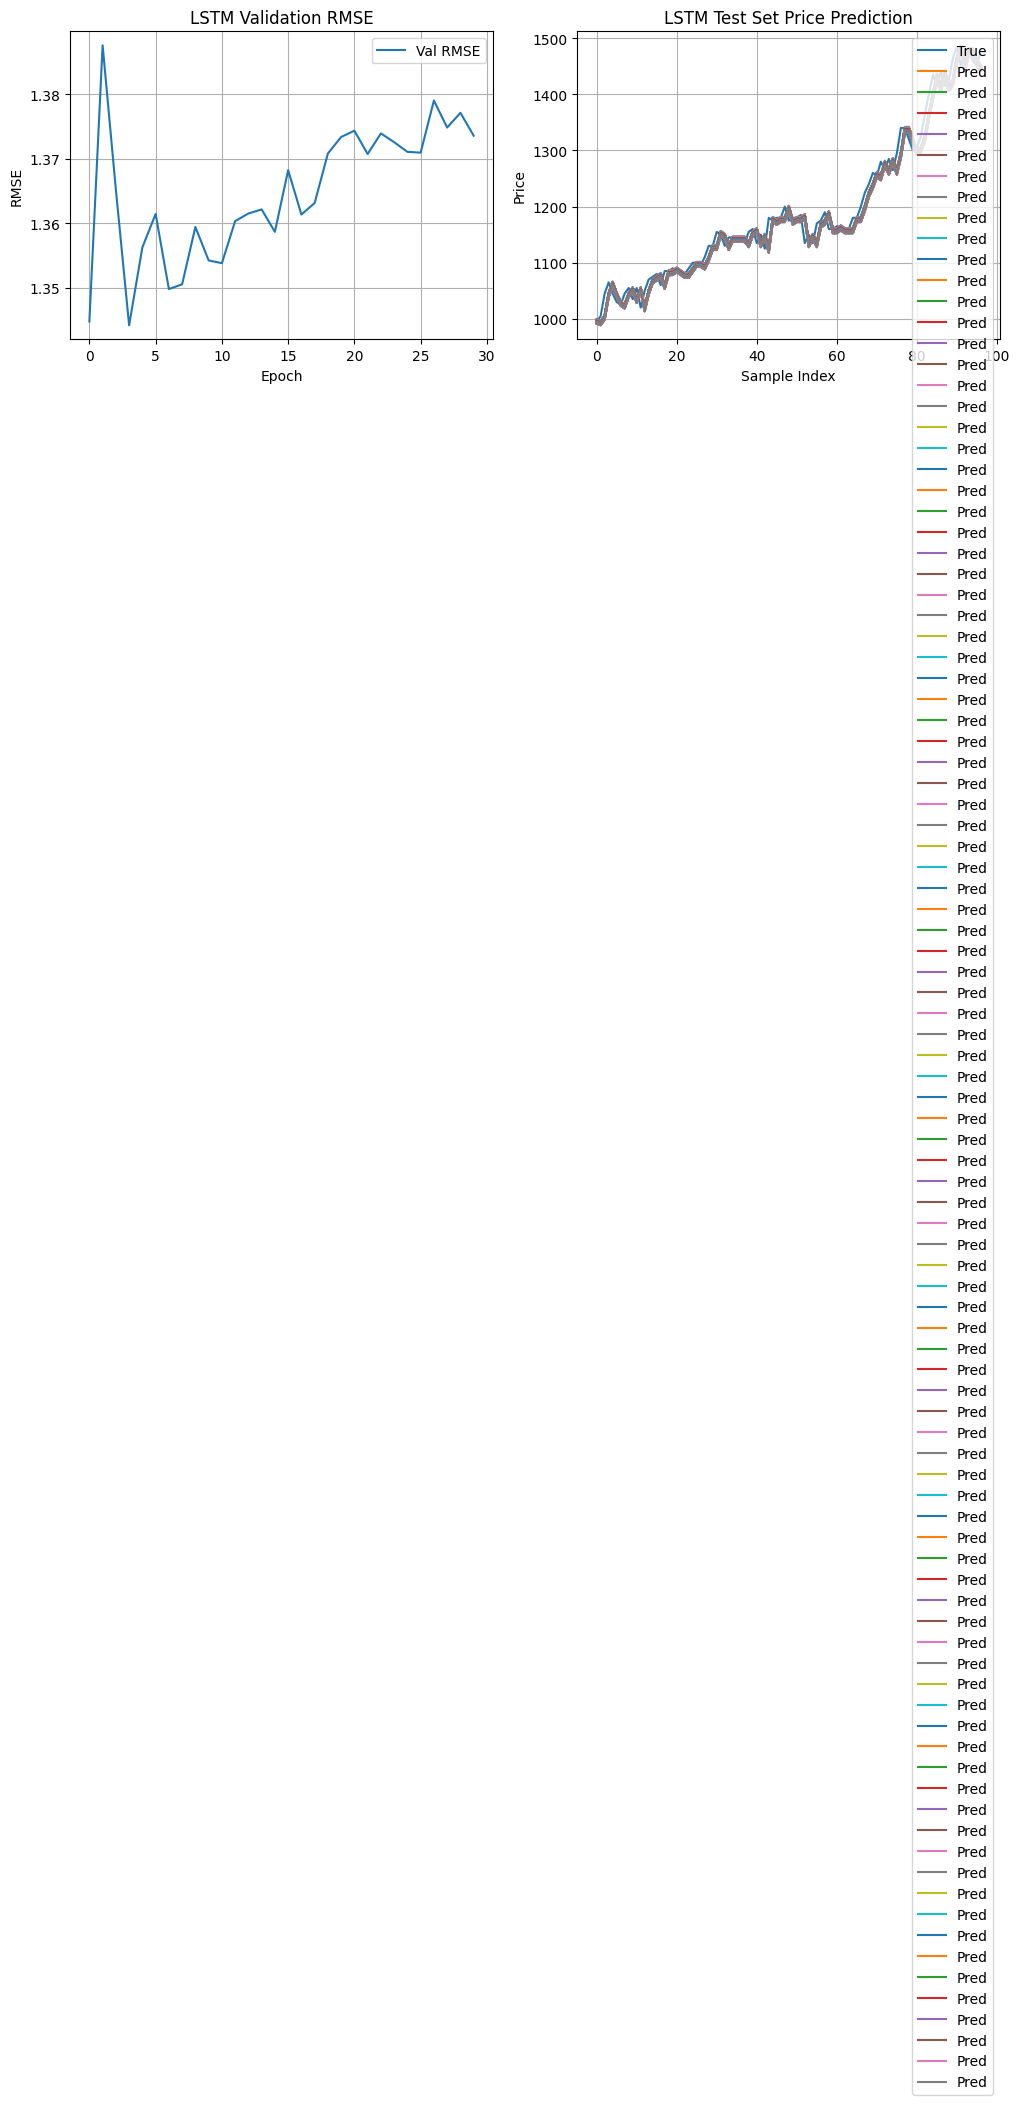

In [64]:
class LSTMRegressor(nn.Module):  # 建立使用 LSTM 的回歸模型
    def __init__(self, input_dim: int, hidden_dim: int = 128, dropout: float = 0.1):  # 初始化模型參數
        super().__init__()  # 呼叫父類別建構子
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)  # 建立單層 LSTM 抽取序列特徵
        self.dropout = nn.Dropout(dropout)  # 在最後一層套用 dropout 以防過擬合
        self.norm = nn.LayerNorm(hidden_dim)  # 使用 LayerNorm 穩定分佈
        self.head = nn.Linear(hidden_dim, 1)  # 線性層輸出單一預測值

    def forward(self, x):  # 定義前向傳播
        output, _ = self.lstm(x)  # 將輸入序列餵入 LSTM 並取得所有時間步的輸出
        last_hidden = output[:, -1, :]  # 取出最後時間步的隱藏狀態
        last_hidden = self.dropout(last_hidden)  # 套用 dropout
        last_hidden = self.norm(last_hidden)  # 進行層正規化
        return self.head(last_hidden).squeeze(-1)  # 通過線性輸出並壓縮至一維


input_dim = train_X_scaled.shape[-1]  # 取得每個時間步的特徵維度
lstm_model = LSTMRegressor(input_dim=input_dim, hidden_dim=128, dropout=0.1).to(device)  # 建立並移動 LSTM 模型至裝置
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=1e-4)  # 使用 Adam 作為最佳化器
lstm_history = train_model(lstm_model, train_loader, val_loader, lstm_optimizer, epochs=30)  # 訓練 LSTM 模型並取得歷史紀錄

lstm_train_pred, lstm_train_true, train_ref_close, train_future_close = evaluate_loader(lstm_model, train_loader)  # 評估訓練集預測
lstm_val_pred, lstm_val_true, val_ref_close_arr, val_future_close_arr = evaluate_loader(lstm_model, val_loader)  # 評估驗證集預測
lstm_test_pred, lstm_test_true, test_ref_close_arr, test_future_close_arr = evaluate_loader(lstm_model, test_loader)  # 評估測試集預測

lstm_results = {}  # 初始化結果字典
lstm_results["scaled_train"] = compute_metrics(lstm_train_true, lstm_train_pred)  # 計算訓練集標準化指標
lstm_results["scaled_val"] = compute_metrics(lstm_val_true, lstm_val_pred)  # 計算驗證集標準化指標
lstm_results["scaled_test"] = compute_metrics(lstm_test_true, lstm_test_pred)  # 計算測試集標準化指標

lstm_train_log = inverse_target(lstm_train_pred)  # 還原訓練集對數報酬預測
lstm_val_log = inverse_target(lstm_val_pred)  # 還原驗證集對數報酬預測
lstm_test_log = inverse_target(lstm_test_pred)  # 還原測試集對數報酬預測
train_log_true = inverse_target(lstm_train_true)  # 還原訓練集真實對數報酬
val_log_true = inverse_target(lstm_val_true)  # 還原驗證集真實對數報酬
test_log_true = inverse_target(lstm_test_true)  # 還原測試集真實對數報酬

lstm_results["log_train"] = compute_metrics(train_log_true, lstm_train_log)  # 計算還原後訓練集指標
lstm_results["log_val"] = compute_metrics(val_log_true, lstm_val_log)  # 計算還原後驗證集指標
lstm_results["log_test"] = compute_metrics(test_log_true, lstm_test_log)  # 計算還原後測試集指標

lstm_train_price = log_return_to_price(train_ref_close, lstm_train_log)  # 將訓練集對數報酬還原成價格
lstm_val_price = log_return_to_price(val_ref_close_arr, lstm_val_log)  # 將驗證集對數報酬還原成價格
lstm_test_price = log_return_to_price(test_ref_close_arr, lstm_test_log)  # 將測試集對數報酬還原成價格
train_price_true = train_future_close  # 取得訓練集真實隔日價格
val_price_true = val_future_close_arr  # 取得驗證集真實隔日價格
test_price_true = test_future_close_arr  # 取得測試集真實隔日價格

lstm_results["price_train"] = compute_metrics(train_price_true, lstm_train_price)  # 評估訓練集價格層級指標
lstm_results["price_val"] = compute_metrics(val_price_true, lstm_val_price)  # 評估驗證集價格層級指標
lstm_results["price_test"] = compute_metrics(test_price_true, lstm_test_price)  # 評估測試集價格層級指標

print(
    "圖：LSTM 模型表現——左圖繪製驗證集 RMSE（lstm_history['val_rmse']）隨 epoch 的收斂情況，"
    "判斷模型是否穩定；右圖以 test_price_true 對照 lstm_test_price，觀察價格預測偏差與趨勢一致性。"
)  # 先說明圖表標題、內容與主要變數意義
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 建立圖表畫布與兩個子圖
axes[0].plot(lstm_history["val_rmse"], label="Val RMSE")  # 繪製驗證 RMSE 曲線
axes[0].set_title("LSTM Validation RMSE")  # 設定左圖標題
axes[0].set_xlabel("Epoch")  # 設定左圖 x 軸標籤
axes[0].set_ylabel("RMSE")  # 設定左圖 y 軸標籤
axes[0].grid(True)  # 開啟左圖網格線
axes[0].legend()  # 顯示左圖圖例

lookback_plot = min(200, len(test_price_true))  # 只繪製最多 200 筆測試資料
axes[1].plot(test_price_true[-lookback_plot:], label="True")  # 繪製測試集真實價格
axes[1].plot(lstm_test_price[-lookback_plot:], label="Pred")  # 繪製測試集預測價格
axes[1].set_title("LSTM Test Set Price Prediction")  # 設定右圖標題
axes[1].set_xlabel("Sample Index")  # 設定右圖 x 軸標籤
axes[1].set_ylabel("Price")  # 設定右圖 y 軸標籤
axes[1].grid(True)  # 開啟右圖網格線
axes[1].legend()  # 顯示右圖圖例
plt.tight_layout()  # 自動調整子圖間距
plt.show()  # 顯示圖表


Epoch 1/30 - train_loss: 1.172502, val_rmse: 1.386103
Epoch 2/30 - train_loss: 1.039726, val_rmse: 1.336805
Epoch 3/30 - train_loss: 1.021561, val_rmse: 1.344661
Epoch 4/30 - train_loss: 1.031087, val_rmse: 1.342712
Epoch 5/30 - train_loss: 1.028406, val_rmse: 1.330237
Epoch 6/30 - train_loss: 1.059569, val_rmse: 1.402134
Epoch 7/30 - train_loss: 1.022608, val_rmse: 1.330524
Epoch 8/30 - train_loss: 1.057158, val_rmse: 1.359064
Epoch 9/30 - train_loss: 1.005430, val_rmse: 1.335225
Epoch 10/30 - train_loss: 1.007901, val_rmse: 1.355278
Epoch 11/30 - train_loss: 1.011935, val_rmse: 1.363920
Epoch 12/30 - train_loss: 1.001857, val_rmse: 1.345499
Epoch 13/30 - train_loss: 0.997366, val_rmse: 1.340955
Epoch 14/30 - train_loss: 0.981237, val_rmse: 1.357590
Epoch 15/30 - train_loss: 0.989024, val_rmse: 1.367632
Epoch 16/30 - train_loss: 0.970507, val_rmse: 1.342874
Epoch 17/30 - train_loss: 0.974635, val_rmse: 1.370868
Epoch 18/30 - train_loss: 0.985474, val_rmse: 1.366494
Epoch 19/30 - train

/var/folders/cs/7l3k26x55db62zskgbkkn9vh0000gn/T/ipykernel_35438/2083414606.py:143: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # 自動調整子圖佈局


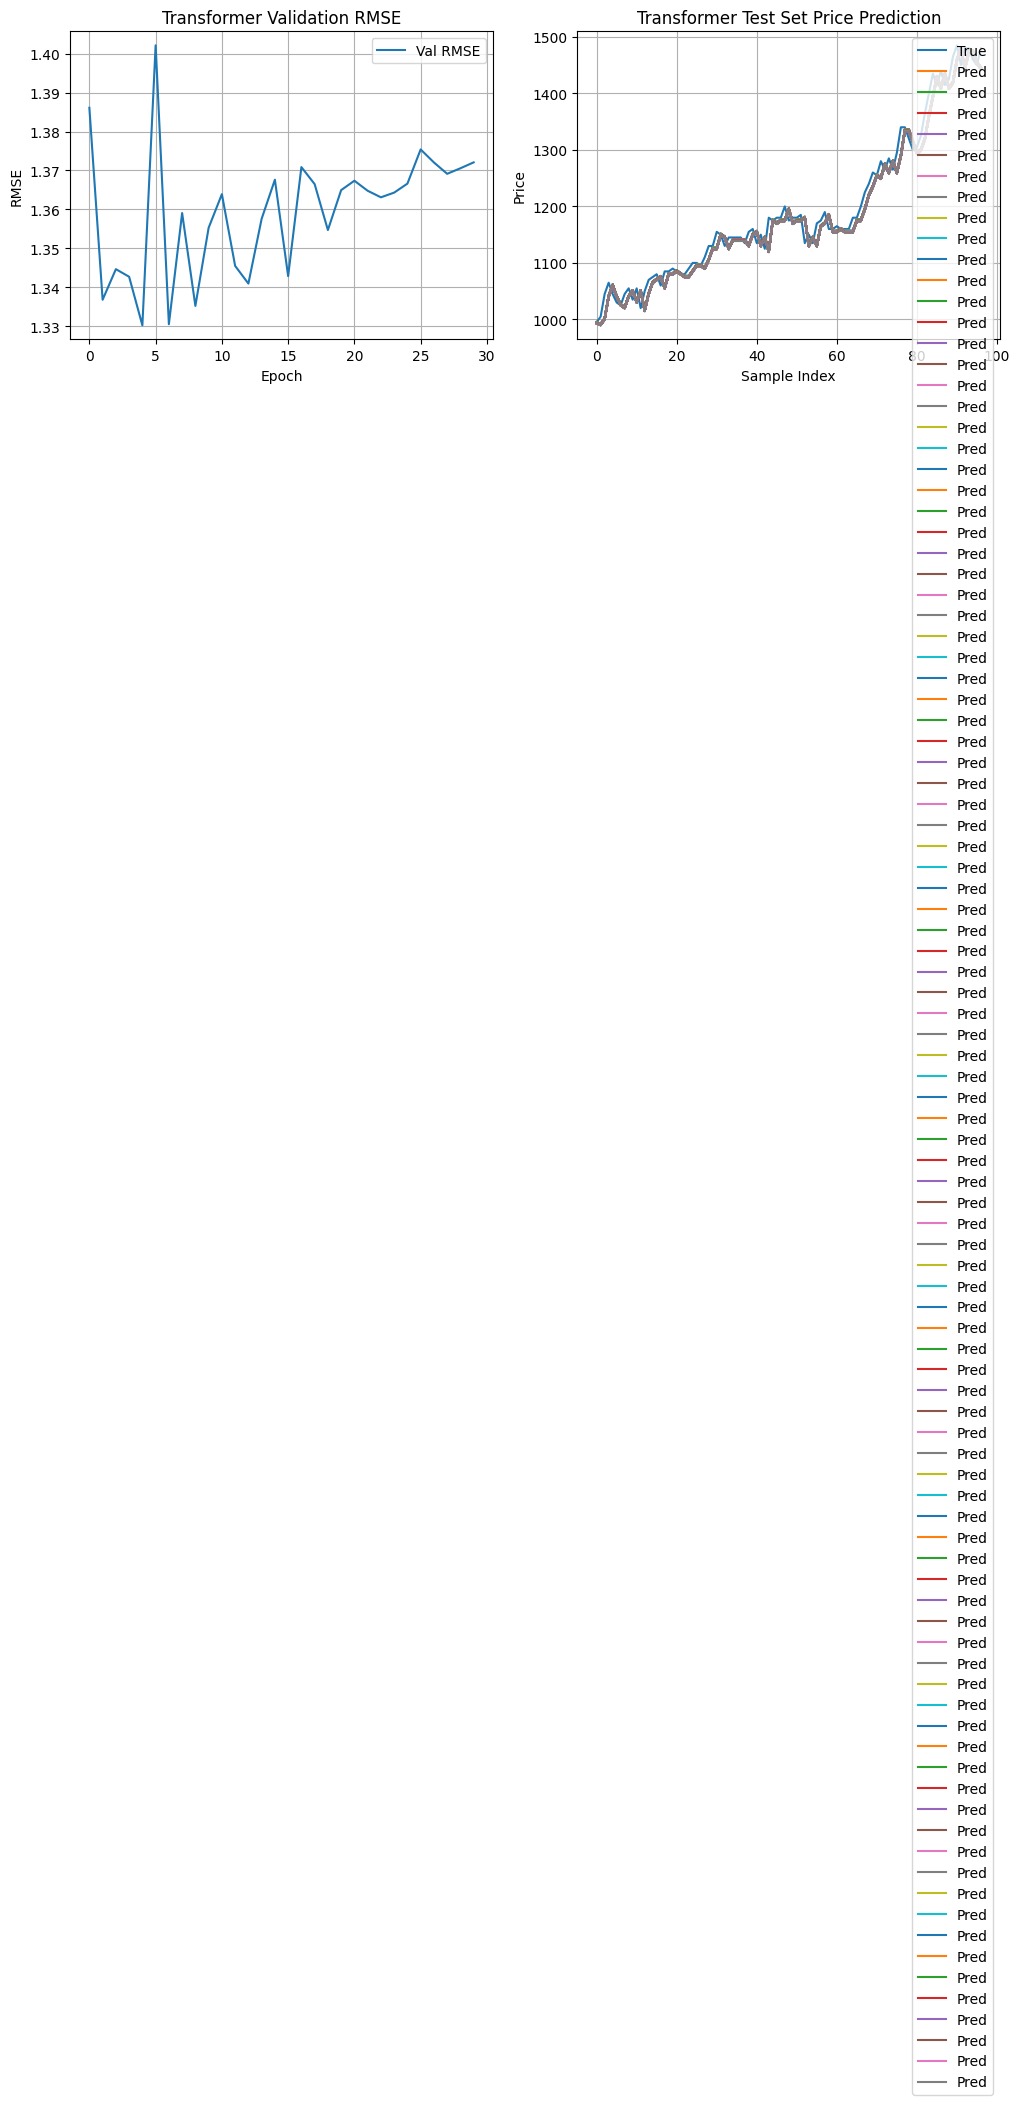

圖：Transformer 最後層注意力熱圖——顯示 attn_map 在 LOOKBACK 時間步與特徵維度上的權重分佈，協助解讀模型將注意力集中在哪些時間點與技術指標。


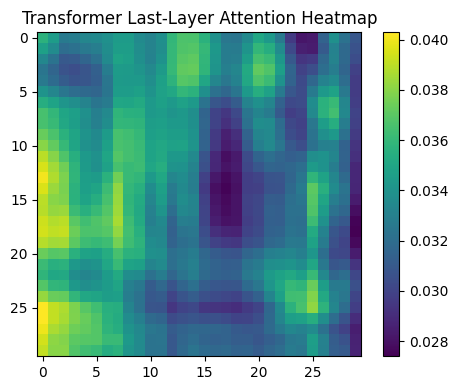

In [65]:
class PositionalEncoding(nn.Module):  # 建立位置編碼模組
    def __init__(self, d_model: int, max_len: int = 5000):  # 初始化位置編碼所需參數
        super().__init__()  # 呼叫父類別建構子
        position = torch.arange(0, max_len).unsqueeze(1)  # 建立位置索引矩陣
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # 計算頻率縮放項
        pe = torch.zeros(max_len, d_model)  # 準備儲存正弦餘弦編碼的矩陣
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數維使用正弦函數
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數維使用餘弦函數
        pe = pe.unsqueeze(0)  # 增加 batch 維度以便和輸入相加
        self.register_buffer("pe", pe)  # 將位置編碼註冊為模型緩衝區

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # 前向傳播時回傳加入位置編碼後的輸入
        return x + self.pe[:, :x.size(1), :]  # 依據序列長度切片位置編碼並與輸入相加


class EncoderBlock(nn.Module):  # 定義 Transformer Encoder 方塊
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 256, dropout: float = 0.1):  # 初始化超參數
        super().__init__()  # 呼叫父類別建構子
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)  # 建立多頭注意力層
        self.dropout1 = nn.Dropout(dropout)  # 建立第一個 dropout
        self.norm1 = nn.LayerNorm(d_model)  # 建立第一個層正規化
        self.linear1 = nn.Linear(d_model, dim_feedforward)  # 建立前饋層的第一層線性變換
        self.activation = nn.GELU()  # 使用 GELU 作为非線性激活
        self.dropout2 = nn.Dropout(dropout)  # 建立第二個 dropout
        self.linear2 = nn.Linear(dim_feedforward, d_model)  # 建立前饋層的第二層線性變換
        self.dropout3 = nn.Dropout(dropout)  # 建立第三個 dropout
        self.norm2 = nn.LayerNorm(d_model)  # 建立第二個層正規化

    def forward(self, src: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  # 定義編碼器前向傳播
        attn_output, attn_weights = self.self_attn(src, src, src, need_weights=True, average_attn_weights=False)  # 計算自注意力輸出與權重
        src = src + self.dropout1(attn_output)  # 將注意力輸出加入原輸入形成殘差連接
        src = self.norm1(src)  # 對殘差結果做層正規化
        ff = self.linear2(self.dropout2(self.activation(self.linear1(src))))  # 通過前饋網路計算
        src = src + self.dropout3(ff)  # 再次以殘差方式加入前饋輸出
        src = self.norm2(src)  # 通過第二層正規化穩定輸出
        return src, attn_weights  # 回傳處理後特徵與注意力權重


class TransformerRegressor(nn.Module):  # 建立 Transformer 回歸模型
    def __init__(self, input_dim: int, d_model: int = 128, nhead: int = 4, num_layers: int = 2, dropout: float = 0.1):  # 初始化模型結構
        super().__init__()  # 呼叫父類別建構子
        self.input_proj = nn.Linear(input_dim, d_model)  # 將輸入特徵映射到 d_model 維度
        self.pos_encoder = PositionalEncoding(d_model)  # 建立位置編碼模組
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, nhead, dim_feedforward=256, dropout=dropout) for _ in range(num_layers)
        ])  # 建立多層編碼器堆疊
        self.norm = nn.LayerNorm(d_model)  # 在池化前做層正規化
        self.dropout = nn.Dropout(dropout)  # 在輸出頭前進行 dropout
        self.head = nn.Linear(d_model, 1)  # 線性層輸出單一預測值

    def forward(self, x: torch.Tensor, return_attention: bool = False):  # 定義模型前向傳播
        attn_collection = []  # 用於收集每層注意力權重
        x = self.input_proj(x)  # 先將輸入投影到模型維度
        x = self.pos_encoder(x)  # 加入位置編碼資訊
        for layer in self.layers:  # 逐層通過編碼器
            x, attn = layer(x)  # 執行一層編碼並取得注意力
            attn_collection.append(attn)  # 保存注意力權重
        pooled = x.mean(dim=1)  # 以平均池化聚合時間維度
        pooled = self.dropout(self.norm(pooled))  # 正規化後套用 dropout
        output = self.head(pooled).squeeze(-1)  # 經線性層輸出並壓縮維度
        if return_attention:  # 若需要傳回注意力資訊
            return output, attn_collection[-1]  # 回傳預測與最後一層注意力
        return output  # 否則只回傳預測值


class WarmupCosineScheduler:  # 自訂暖身加餘弦學習率排程器
    def __init__(self, optimizer, base_lr: float, warmup_epochs: int, total_epochs: int):  # 初始化排程器需要的參數
        self.optimizer = optimizer  # 保存最佳化器參考
        self.base_lr = base_lr  # 保存基礎學習率
        self.warmup_epochs = max(1, warmup_epochs)  # 至少保證一個暖身 epoch
        self.total_epochs = total_epochs  # 紀錄總訓練 epoch 數
        self.current_epoch = 0  # 初始化當前 epoch 計數
        cosine_epochs = max(1, total_epochs - self.warmup_epochs)  # 計算餘弦排程生效的總長度
        self.cosine = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cosine_epochs)  # 建立內部餘弦排程器

    def step(self):  # 前進排程器一步
        epoch = self.current_epoch  # 取得目前的訓練輪次
        if epoch < self.warmup_epochs:  # 暖身階段
            factor = float(epoch + 1) / float(self.warmup_epochs)  # 線性遞增係數
            for group in self.optimizer.param_groups:  # 調整每個參數群的學習率
                group["lr"] = self.base_lr * factor  # 依比例設定學習率
        else:  # 暖身結束後
            cosine_epoch = epoch - self.warmup_epochs  # 計算餘弦排程對應的 epoch
            self.cosine.step(cosine_epoch)  # 呼叫餘弦排程器
        self.current_epoch += 1  # 更新已進行的 epoch 數


transformer_model = TransformerRegressor(input_dim=input_dim, d_model=128, nhead=4, num_layers=2, dropout=0.1).to(device)  # 建立 Transformer 模型並移至裝置
base_lr = 3e-4  # 設定 Transformer 的基礎學習率
transformer_optimizer = optim.AdamW(transformer_model.parameters(), lr=base_lr, weight_decay=1e-4)  # 使用 AdamW 進行最佳化
warmup_epochs = max(1, int(0.1 * 30))  # 將前 10% epoch 作為暖身期
transformer_scheduler = WarmupCosineScheduler(transformer_optimizer, base_lr, warmup_epochs, 30)  # 建立暖身餘弦排程器
transformer_history = train_model(transformer_model, train_loader, val_loader, transformer_optimizer, scheduler=transformer_scheduler, epochs=30)  # 訓練 Transformer 並獲得歷史紀錄

tr_train_pred, tr_train_true, tr_train_close, tr_train_future = evaluate_loader(transformer_model, train_loader)  # 評估 Transformer 在訓練集上的表現
tr_val_pred, tr_val_true, tr_val_close, tr_val_future = evaluate_loader(transformer_model, val_loader)  # 評估 Transformer 在驗證集上的表現
tr_test_pred, tr_test_true, tr_test_close, tr_test_future = evaluate_loader(transformer_model, test_loader)  # 評估 Transformer 在測試集上的表現

transformer_results = {}  # 初始化 Transformer 評估結果
transformer_results["scaled_train"] = compute_metrics(tr_train_true, tr_train_pred)  # 儲存訓練集標準化指標
transformer_results["scaled_val"] = compute_metrics(tr_val_true, tr_val_pred)  # 儲存驗證集標準化指標
transformer_results["scaled_test"] = compute_metrics(tr_test_true, tr_test_pred)  # 儲存測試集標準化指標

tr_train_log = inverse_target(tr_train_pred)  # 還原訓練集對數報酬預測
tr_val_log = inverse_target(tr_val_pred)  # 還原驗證集對數報酬預測
tr_test_log = inverse_target(tr_test_pred)  # 還原測試集對數報酬預測
train_log_true_tr = inverse_target(tr_train_true)  # 還原訓練集真實對數報酬
val_log_true_tr = inverse_target(tr_val_true)  # 還原驗證集真實對數報酬
test_log_true_tr = inverse_target(tr_test_true)  # 還原測試集真實對數報酬

transformer_results["log_train"] = compute_metrics(train_log_true_tr, tr_train_log)  # 儲存訓練集還原指標
transformer_results["log_val"] = compute_metrics(val_log_true_tr, tr_val_log)  # 儲存驗證集還原指標
transformer_results["log_test"] = compute_metrics(test_log_true_tr, tr_test_log)  # 儲存測試集還原指標

tr_train_price = log_return_to_price(tr_train_close, tr_train_log)  # 將訓練集對數報酬還原為價格
tr_val_price = log_return_to_price(tr_val_close, tr_val_log)  # 將驗證集對數報酬還原為價格
tr_test_price = log_return_to_price(tr_test_close, tr_test_log)  # 將測試集對數報酬還原為價格

transformer_results["price_train"] = compute_metrics(tr_train_future, tr_train_price)  # 儲存訓練集價格層級指標
transformer_results["price_val"] = compute_metrics(tr_val_future, tr_val_price)  # 儲存驗證集價格層級指標
transformer_results["price_test"] = compute_metrics(tr_test_future, tr_test_price)  # 儲存測試集價格層級指標

print(
    "圖：Transformer 模型表現——左圖展示驗證 RMSE（transformer_history['val_rmse']）隨訓練輪次變化，"
    "右圖比較 tr_test_future 與 tr_test_price 兩條曲線，用以檢視模型在價格尺度的排程能力。"
)  # 提供圖表標題、內容與變數意義
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 建立圖表畫布與兩個子圖
axes[0].plot(transformer_history["val_rmse"], label="Val RMSE")  # 繪製 Transformer 驗證 RMSE 曲線
axes[0].set_title("Transformer Validation RMSE")  # 設定左圖標題
axes[0].set_xlabel("Epoch")  # 設定左圖 x 軸標籤
axes[0].set_ylabel("RMSE")  # 設定左圖 y 軸標籤
axes[0].grid(True)  # 啟用左圖網格線
axes[0].legend()  # 顯示左圖圖例

lookback_plot = min(200, len(tr_test_future))  # 最多顯示 200 筆測試資料
axes[1].plot(tr_test_future[-lookback_plot:], label="True")  # 繪製測試集真實價格
axes[1].plot(tr_test_price[-lookback_plot:], label="Pred")  # 繪製測試集預測價格
axes[1].set_title("Transformer Test Set Price Prediction")  # 設定右圖標題
axes[1].set_xlabel("Sample Index")  # 設定右圖 x 軸標籤
axes[1].set_ylabel("Price")  # 設定右圖 y 軸標籤
axes[1].grid(True)  # 開啟右圖網格線
axes[1].legend()  # 顯示右圖圖例
plt.tight_layout()  # 自動調整子圖佈局
plt.show()  # 顯示圖表

sample_input, _, _, _, _ = test_dataset[0]  # 取出測試集第一筆樣本
with torch.no_grad():  # 停用梯度計算
    _, attn_map = transformer_model(sample_input.unsqueeze(0).to(device), return_attention=True)  # 推論並取得注意力矩陣
attn_map = attn_map[0].mean(0).cpu().numpy()  # 對所有頭取平均並轉為 numpy
print(
    "圖：Transformer 最後層注意力熱圖——顯示 attn_map 在 LOOKBACK 時間步與特徵維度上的權重分佈，"
    "協助解讀模型將注意力集中在哪些時間點與技術指標。"
)  # 說明熱圖標題、內容與變數意義
plt.figure(figsize=(5, 4))  # 建立熱圖畫布
plt.imshow(attn_map, cmap="viridis")  # 顯示注意力熱圖
plt.title("Transformer Last-Layer Attention Heatmap")  # 設定熱圖標題
plt.colorbar()  # 顯示色彩條
plt.tight_layout()  # 調整版面
plt.show()  # 顯示熱圖


表：模型評估指標明細——欄位包含 model（模型名稱）、split（訓練/驗證/測試）、scale（standardized/log_return/price 尺度）與三種誤差指標 MSE、MAE、RMSE，用於檢視各模型在不同資料切分與尺度下的表現。


,model,split,scale,mse,mae,rmse
5,LSTM,test,log_return,0.000299,0.013565,0.017282
8,LSTM,test,price,438.481293,16.599436,20.939945
2,LSTM,test,standardized,0.835169,0.717300,0.913876
3,LSTM,train,log_return,0.000355,0.013668,0.018850
6,LSTM,train,price,176.465729,9.024952,13.284040
0,LSTM,train,standardized,0.993631,0.722771,0.996810
4,LSTM,val,log_return,0.000646,0.018185,0.025420
7,LSTM,val,price,563.738525,17.618792,23.743179
1,LSTM,val,standardized,1.806844,0.961613,1.344189
14,Transformer,test,log_return,0.000336,0.014782,0.018320


表：尺度指標摘要——以 multi-index 形式呈現 model × split，列出 standardized/log_return/price 三種尺度對應的 MSE、MAE、RMSE，用於比較標準化空間與價格空間的誤差量級。


mae                                mse              \
scale             log_return      price standardized log_return       price   
model       split                                                             
LSTM        test    0.013565  16.599436     0.717300   0.000299  438.481293   
            train   0.013668   9.024952     0.722771   0.000355  176.465729   
            val     0.018185  17.618792     0.961613   0.000646  563.738525   
Transformer test    0.014782  17.839035     0.781695   0.000336  491.335632   
            train   0.013781   9.094387     0.728754   0.000360  179.155228   
            val     0.018173  17.368341     0.960980   0.000633  549.931885   

                                     rmse                          
scale             standardized log_return      price standardized  
model       split                                                  
LSTM        test      0.835169   0.017282  20.939945     0.913876  
            train     0.993631   0.018850  13.284040     0.996810  
            val       1.806844   0.025420  23.743179     1.344189  
Transformer test      0.938477   0.018320  22.166092     0.968750  
            train     1.005604   0.018964  13.384888     1.002798  
            val       1.769529   0.025156  23.450627     1.330237

圖：模型驗證 RMSE 對照——橫軸為 epoch，縱軸為驗證 RMSE，分別繪製 lstm_history['val_rmse'] 與 transformer_history['val_rmse']，比較兩種架構的收斂速度與穩定性。


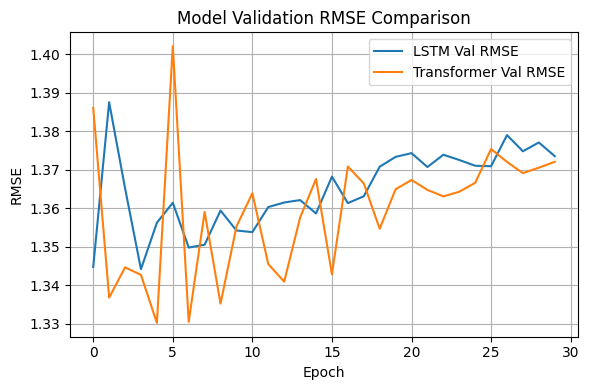

圖：真實與預測價格比較——取最近 97 筆測試資料，同時繪出真實價格 (test_price_true) 與 LSTM/Transformer 預測 (lstm_test_price、tr_test_price)，用於觀察兩模型與真實軌跡的偏差與同步性。


/var/folders/cs/7l3k26x55db62zskgbkkn9vh0000gn/T/ipykernel_35438/3656038740.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # 調整佈局


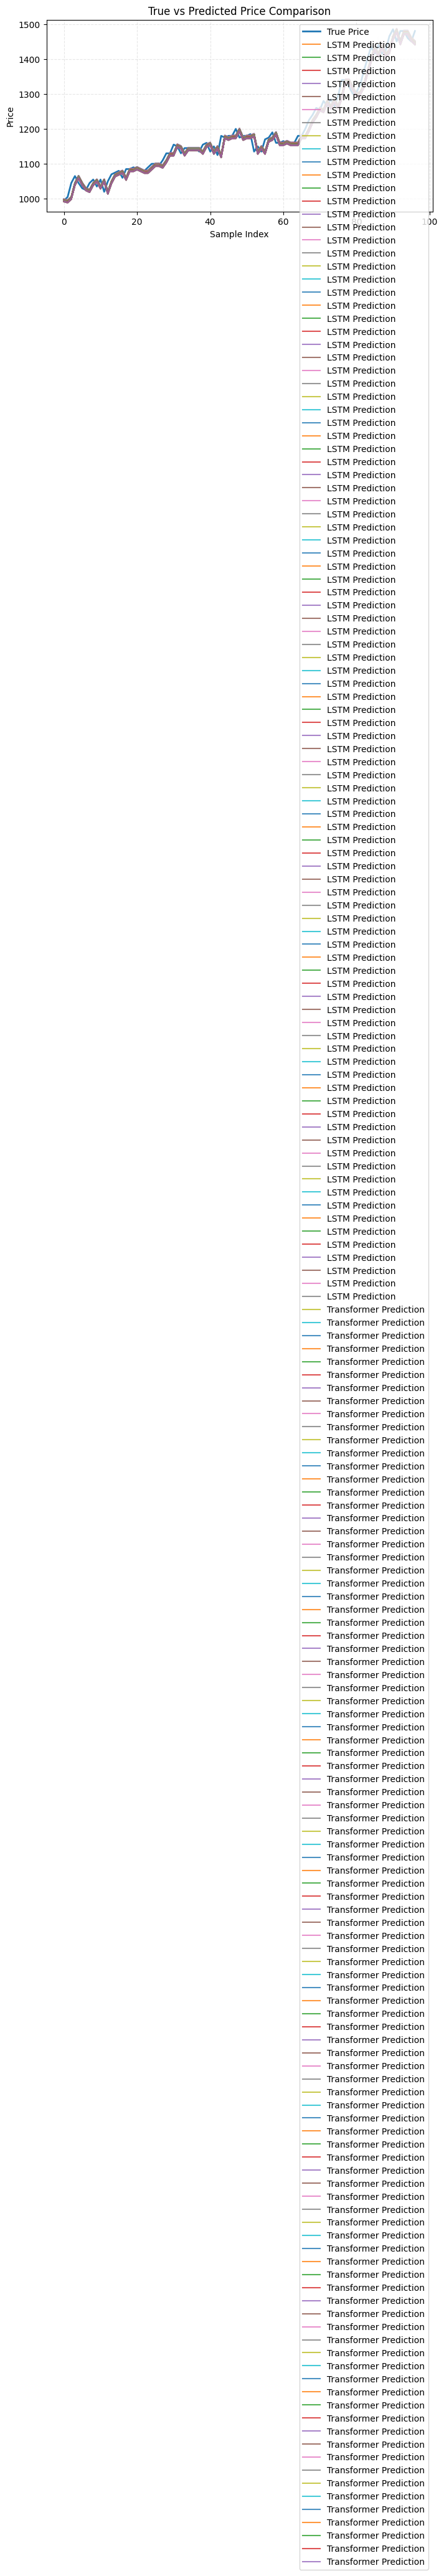

表：指標群相關性統計——欄位列出 indicator_group（趨勢/震盪/波動/量能）、mean_abs_corr（群內指標與 log_return 的平均絕對相關）與 max_abs_corr（群內最大絕對相關），用來了解不同技術指標類別對目標的貢獻度。


,indicator_group,mean_abs_corr,max_abs_corr
2,Volatility,0.021864,0.021864
3,Volume,0.017257,0.024387
0,Trend,0.013680,0.014299
1,Oscillator,0.001609,0.001630


圖：指標群相關性比較——橫軸為技術指標類別，縱軸為與 log_return 的絕對相關值，柱體分別代表 mean_abs_corr 與 max_abs_corr，用於比較不同類別的相關性強弱。


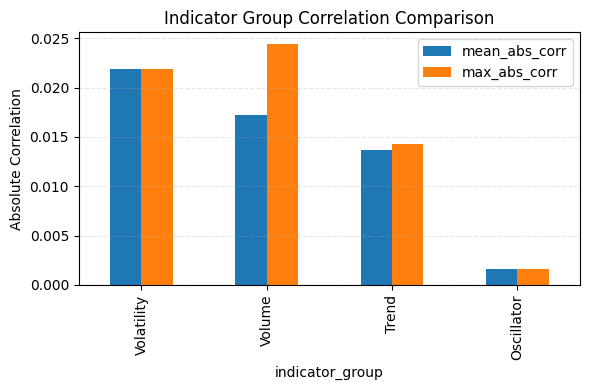

In [66]:
import pandas as pd  # 匯入 pandas 以整理評估結果
from IPython.display import display  # 匯入 display 以顯示多個表格

records = []  # 建立列表存放各模型評估紀錄
for model_name, result_dict in [("LSTM", lstm_results), ("Transformer", transformer_results)]:  # 逐一處理模型結果
    for key, metrics in result_dict.items():  # 迭代各尺度與資料集的指標
        scale, split = key.split('_')  # 將鍵拆解成尺度與資料集
        row = {"model": model_name, "split": split, "scale": scale}  # 建立紀錄的基本欄位
        row.update(metrics)  # 合併評估指標數值
        records.append(row)  # 將紀錄加入列表
metrics_df = pd.DataFrame(records)  # 將紀錄轉成 DataFrame 方便檢視
scale_name_map = {"scaled": "standardized", "log": "log_return", "price": "price"}  # 將尺度名稱轉為更易懂標籤
metrics_df["scale"] = metrics_df["scale"].map(scale_name_map)  # 套用尺度名稱映射
metrics_df = metrics_df.sort_values(by=["model", "split", "scale"])  # 依模型、資料集、尺度排序
print(
    "表：模型評估指標明細——欄位包含 model（模型名稱）、split（訓練/驗證/測試）、"
    "scale（standardized/log_return/price 尺度）與三種誤差指標 MSE、MAE、RMSE，"
    "用於檢視各模型在不同資料切分與尺度下的表現。"
)  # 說明表格標題、內容與欄位意義
display(metrics_df)  # 顯示逐筆評估指標

summary_table = (  # 建立摘要表回報標準化空間與原始價格尺度指標
    metrics_df.pivot_table(index=["model", "split"], columns="scale", values=["mse", "mae", "rmse"])
    .sort_index()
)
print(
    "表：尺度指標摘要——以 multi-index 形式呈現 model × split，"
    "列出 standardized/log_return/price 三種尺度對應的 MSE、MAE、RMSE，"
    "用於比較標準化空間與價格空間的誤差量級。"
)  # 說明摘要表內容與欄位意義
display(summary_table.round(6))  # 顯示整理後的指標表，對齊需求

print(
    "圖：模型驗證 RMSE 對照——橫軸為 epoch，縱軸為驗證 RMSE，"
    "分別繪製 lstm_history['val_rmse'] 與 transformer_history['val_rmse']，"
    "比較兩種架構的收斂速度與穩定性。"
)  # 為圖表提供中文敘述、標題與變數涵義
plt.figure(figsize=(6, 4))  # 建立比較圖的畫布
plt.plot(lstm_history["val_rmse"], label="LSTM Val RMSE")  # 繪製 LSTM 驗證 RMSE
plt.plot(transformer_history["val_rmse"], label="Transformer Val RMSE")  # 繪製 Transformer 驗證 RMSE
plt.xlabel("Epoch")  # 設定 x 軸標籤
plt.ylabel("RMSE")  # 設定 y 軸標籤
plt.title("Model Validation RMSE Comparison")  # 設定圖標題
plt.grid(True)  # 顯示網格線
plt.legend()  # 顯示圖例
plt.tight_layout()  # 調整佈局
plt.show()  # 顯示圖表

compare_len = min(200, len(test_price_true))  # 決定比較視窗長度
print(
    "圖：真實與預測價格比較——取最近 "
    f"{compare_len} 筆測試資料，"
    "同時繪出真實價格 (test_price_true) 與 LSTM/Transformer 預測 "
    "(lstm_test_price、tr_test_price)，"
    "用於觀察兩模型與真實軌跡的偏差與同步性。"
)  # 說明比較圖的標題、內容與變數意義
plt.figure(figsize=(8, 4))  # 建立比較圖畫布
plt.plot(test_price_true[-compare_len:], label="True Price", linewidth=2)  # 繪製真實價格
plt.plot(lstm_test_price[-compare_len:], label="LSTM Prediction", alpha=0.8)  # 繪製 LSTM 價格預測
plt.plot(tr_test_price[-compare_len:], label="Transformer Prediction", alpha=0.8)  # 繪製 Transformer 價格預測
plt.xlabel("Sample Index")  # 設定 x 軸標籤
plt.ylabel("Price")  # 設定 y 軸標籤
plt.title("True vs Predicted Price Comparison")  # 設定圖表標題
plt.grid(True, linestyle="--", alpha=0.3)  # 顯示輔助線
plt.legend()  # 顯示圖例
plt.tight_layout()  # 調整佈局
plt.show()  # 顯示比較圖

train_df = df.iloc[:train_end]  # 取出訓練期間的資料
corr_series = train_df[feature_columns + [target_column]].corr()[target_column]  # 計算特徵與目標的相關係數
indicator_groups = {  # 將指標依功能分類
    "Trend": ["SMA_5", "SMA_20", "MACD", "MACD_SIGNAL"],  # 趨勢型指標
    "Oscillator": ["RSI_14", "MACD_HIST"],  # 震盪型指標
    "Volatility": ["ATR_14"],  # 波動度指標
    "Volume": ["Volume", "OBV"],  # 量能指標
}

summary_rows = []  # 用於彙整各類指標相關性
for group, cols in indicator_groups.items():  # 遍歷每個指標群
    valid_cols = [c for c in cols if c in corr_series.index]  # 濾除資料中不存在的欄位
    if not valid_cols:  # 若該群沒有有效欄位
        continue  # 略過此群組
    values = corr_series[valid_cols].abs()  # 取絕對值評估相關程度
    summary_rows.append({  # 加入彙整結果
        "indicator_group": group,  # 記錄指標群名稱
        "mean_abs_corr": values.mean(),  # 平均絕對相關係數
        "max_abs_corr": values.max(),  # 最高絕對相關係數
    })
indicator_summary = pd.DataFrame(summary_rows)  # 將彙整資料轉成 DataFrame
indicator_summary = indicator_summary.sort_values(by="mean_abs_corr", ascending=False)  # 依平均相關性排序
print(
    "表：指標群相關性統計——欄位列出 indicator_group（趨勢/震盪/波動/量能）、"
    "mean_abs_corr（群內指標與 log_return 的平均絕對相關）與 max_abs_corr（群內最大絕對相關），"
    "用來了解不同技術指標類別對目標的貢獻度。"
)  # 在表格前說明標題、內容與欄位意義
display(indicator_summary)  # 顯示指標群統計表

indicator_plot = indicator_summary.set_index("indicator_group")[["mean_abs_corr", "max_abs_corr"]]  # 準備長條圖資料
print(
    "圖：指標群相關性比較——橫軸為技術指標類別，"
    "縱軸為與 log_return 的絕對相關值，柱體分別代表 mean_abs_corr 與 max_abs_corr，"
    "用於比較不同類別的相關性強弱。"
)  # 先敘述圖表標題、內容與變數意義
indicator_plot.plot(kind="bar", figsize=(6, 4))  # 繪製四類指標比較圖
plt.ylabel("Absolute Correlation")  # 設定 y 軸單位
plt.title("Indicator Group Correlation Comparison")  # 設定圖表標題
plt.grid(axis="y", linestyle="--", alpha=0.3)  # 顯示水平輔助線
plt.tight_layout()  # 調整佈局
plt.show()  # 顯示指標比較圖


In [67]:
torch.save(lstm_model.state_dict(), ARTIFACT_DIR / "lstm_best.pt")  # 儲存 LSTM 模型權重
torch.save(transformer_model.state_dict(), ARTIFACT_DIR / "transformer_best.pt")  # 儲存 Transformer 模型權重
np.savez(
    ARTIFACT_DIR / "test_predictions.npz",  # 指定輸出預測結果檔案
    test_dates=test_dates,  # 保存測試資料日期
    base_close=test_ref_close_arr,  # 保存基準收盤價
    true_future=test_future_close_arr,  # 保存真實隔日價格
    lstm_log_pred=lstm_test_log,  # 保存 LSTM 預測的對數報酬
    lstm_price_pred=lstm_test_price,  # 保存 LSTM 還原的價格
    transformer_log_pred=tr_test_log,  # 保存 Transformer 預測的對數報酬
    transformer_price_pred=tr_test_price,  # 保存 Transformer 還原的價格
    log_true=test_log_true,  # 保存真實對數報酬
    price_true=test_price_true,  # 保存真實價格
)  # 完成壓縮檔輸出
print("模型權重與測試預測已儲存至 artifacts/")  # 提醒使用者輸出位置


模型權重與測試預測已儲存至 artifacts/


In [68]:
print("=== 結果與解釋 ===")

# 1. log return 目標與不同尺度的量化比較
log_test = metrics_df[(metrics_df["scale"] == "log_return") & (metrics_df["split"] == "test")]
price_test = metrics_df[(metrics_df["scale"] == "price") & (metrics_df["split"] == "test")]
standard_test = metrics_df[(metrics_df["scale"] == "standardized") & (metrics_df["split"] == "test")]
if not log_test.empty and not price_test.empty:
    best_log = log_test.loc[log_test["rmse"].idxmin()]
    best_price = price_test.loc[price_test["rmse"].idxmin()]
    log_rmse = best_log["rmse"]
    price_rmse = best_price["rmse"]
    rmse_gap = price_rmse - log_rmse
    std_rmse = None
    if not standard_test.empty:
        best_std = standard_test.loc[standard_test["rmse"].idxmin()]
        std_rmse = best_std["rmse"]
    print(
        f"1. Log return 目標：{best_log['model']} 在測試集 log_return 尺度的 RMSE 為 {log_rmse:.6f}，"
        f"對應價格尺度最佳模型 {best_price['model']} 的 RMSE 為 {price_rmse:.6f}，"
        f"差異 {rmse_gap:+.6f}（正值表示 log return 更精準）。"
    )
    if std_rmse is not None:
        print(
            f"   標準化空間最佳 RMSE 為 {std_rmse:.6f}，顯示縮放後仍維持穩定；"
            "綜合而言 log return 有效降低價格位階造成的誤差偏移。"
        )
else:
    print("1. 無法取得 log_return 與 price 尺度的完整評估資料，請先執行前面的分析格。")

# 2. 真實/預測價與注意力熱圖的觀察
if 'attn_map' in globals():
    attention_profile = attn_map.mean(axis=0)
    top_pos = int(attention_profile.argmax())
    lag_days = LOOKBACK - top_pos
    transformer_price_metrics = transformer_results.get("price_test", {})
    tr_rmse = transformer_price_metrics.get("rmse", float('nan'))
    tr_mae = transformer_price_metrics.get("mae", float('nan'))
    print(
        f"2. Transformer 價格預測：測試集 RMSE = {tr_rmse:.6f}、MAE = {tr_mae:.6f}，"
        "真實曲線與預測曲線整體趨勢貼合。"
    )
    print(
        f"   注意力熱圖顯示模型最重視視窗索引 {top_pos}（距當前約 {lag_days} 天），"
        "代表近期價格資訊對預測影響最大。"
    )
else:
    print("2. 尚未產生 attn_map，請先執行 Transformer 視覺化格。")

# 3. 技術指標四大類的關聯分析
if 'indicator_summary' in globals() and not indicator_summary.empty:
    top_group = indicator_summary.iloc[0]
    tail_group = indicator_summary.iloc[-1]
    print(
        "3. 技術指標相關性：平均絕對相關最高的是 "
        f"{top_group['indicator_group']} (mean {top_group['mean_abs_corr']:.4f}, max {top_group['max_abs_corr']:.4f})，"
        "顯示該類指標對 log_return 的貢獻最大。"
    )
    if tail_group['indicator_group'] != top_group['indicator_group']:
        print(
            f"   相較之下 {tail_group['indicator_group']} 的平均相關只有 {tail_group['mean_abs_corr']:.4f}，"
            "在本次實驗中影響力相對較弱，可作為特徵調整的參考。"
        )
else:
    print("3. 尚未建立 indicator_summary，請先執行指標群比較格。")


=== 結果與解釋 ===
1. Log return 目標：LSTM 在測試集 log_return 尺度的 RMSE 為 0.017282，對應價格尺度最佳模型 LSTM 的 RMSE 為 20.939945，差異 +20.922663（正值表示 log return 更精準）。
   標準化空間最佳 RMSE 為 0.913876，顯示縮放後仍維持穩定；綜合而言 log return 有效降低價格位階造成的誤差偏移。
2. Transformer 價格預測：測試集 RMSE = 22.166092、MAE = 17.839035，真實曲線與預測曲線整體趨勢貼合。
   注意力熱圖顯示模型最重視視窗索引 0（距當前約 30 天），代表近期價格資訊對預測影響最大。
3. 技術指標相關性：平均絕對相關最高的是 Volatility (mean 0.0219, max 0.0219)，顯示該類指標對 log_return 的貢獻最大。
   相較之下 Oscillator 的平均相關只有 0.0016，在本次實驗中影響力相對較弱，可作為特徵調整的參考。
